# INFO 2950 Final Project - Phase II

## Research Question:

**Question**: Can we reliably predict the total number of electric vehicle (EV) registration across US states based on trends in renewable energy production, EV prices, charging station availability, government incentives, and other relevant factors?

In this assignment, we collected and cleaned data on key variables relevant to our research question, on a national-level (e.g. EV prices, federal EV incentives) or state-level (e.g. number of charging stations, renewable energy production, EV incentives per state) over time. Our goal for this phase was to explore trends within these explanatory variables and analyze their correlation with our dependent variable—EV registration rates in each state. For the final deliverable, we plan to employ a multivariable fixed effects regression using these (and more) variables to build a predictive model: $$
EV\_registration_{st} = \beta_0 + \beta_1 EV\_Price_t + \beta_2 Federal\_Incentive_t + \beta_3 State\_Incentive_s + \beta_4 Renewable\_Energy_{st} + \beta_5 Charging\_Stations_{st} + \alpha_s + \lambda_t + \epsilon_{st}
$$

While we've collected data across all states, we plan to narrow our focus in analyzing the top 5 states with the highest EV registration in 2023: California, Florida, Texas, Washington, New Jersey – building a model for each of these states. For next steps, we intend to explore additional relevant variables that may enhance the accuracy of our models.

## Data Descriptions:

We collected 5 data tables for this phase: one pertaining to the variable we are aiming to predict, and four input variables for our model.

1. **Vehicle Registration Counts by State**
   * <u>Data Source</u>: US Department of Energy - Alternative Fuels Data Center (AFDC)
   * <u>URL</u>: https://afdc.energy.gov/vehicle-registration?year=2023
    > <u>Description</u>: This page provides approximate light-duty vehicle registration counts derived by the National Renewable Energy Laboratory with data from Experian Information Solutions. Counts are rounded to the closest 100 vehicles and reflect the total number of light-duty registered vehicles through the selected year. Fuel types are based on vehicle identification numbers (VINs), which do not reflect aftermarket conversions to use different fuels or power sources.
<br>
<br>

2. **Renewable and Total Energy Production by State**
    * <u>Data Source</u>: US Energy Information Administration (EIA) – State Energy Data System (SEDS)
    * <u>URL(s)</u>: <br>
        Website - https://www.eia.gov/renewable/data.php <br>
        File - https://www.eia.gov/state/seds/sep_prod/SEDS_Production_Report.pdf (pg 18-119)
    > <u>Description</u>: This report provides estimates of primary energy production (renewable and non-renewable) for all U.S. states from 1960 to 2022. Data is available in both physical units (e.g. short tons, cubic feet) and thermal units (British thermal units, Btu). The report includes various fuel types, including coal, natural gas, crude oil, fuel ethanol, biodiesel, and renewable diesel, offering a comprehensive view of energy production trends over time.
<br>
<br>

3. **EV Retail Prices by Models**
    * <u>Data Source</u>: US Department of Energy - Office of Energy efficiency & Renewable Energy
    * <u>URL</u>: https://www.fueleconomy.gov/feg/PowerSearch.do?action=noform&year1=2016&year2=2023&minmsrpsel=0&maxmsrpsel=0&city=0&hwy=0&comb=0&cbvtelectric=Electric&YearSel=2016-2023&make=&mclass=&vfuel=&vtype=Electric&trany=&drive=&cyl=&MpgSel=000&sortBy=Comb&Units=&url=SearchServlet&opt=new&minmsrp=0&maxmsrp=0&minmpg=0&maxmpg=0&sCharge=&tCharge=&startstop=&cylDeact=&rowLimit=200&pageno=1&tabView=0
    > <u>Description</u>: This official website serves as a resource for consumers looking for detailed, fuel-related data about electric vehicles and allows them to compare EVs across various models and years in terms of price, fuel economy, and other specifications. This page specifically displays a list of electric vehicles (EVs) that match the search criteria set for model years between 2016 and 2023. 
<br>
<br>

4. **EV Charge Stations**
    * <u>Data Source</u>: Open Charge Map 
    * <u>URL</u>: https://openchargemap.org/site/develop/api#/
    > <u>Description</u>: Open Charge Map's API provides access to a global database of electric vehicle charging locations. It offers a range of functionalities, including retrieving nearby charging stations, filtering stations by country, operator, or status, and contributing data such as new locations or updates. The API supports JSON and XML formats, allowing developers to integrate charging point information into apps, navigation systems, or research projects. The data is community-driven and free to use.
<br>
<br>

5. **State Incentives Related to Alternative Fuels and Vehicles**
    * <u>Data Source</u>: US Department of Energy - Alternative Fuels Data Center (AFDC) 
    * <u>URL</u>: https://afdc.energy.gov/laws/state
    > <u>Description</u>: This dataset contains state and federal laws and incentives related to alternative fuels and vehicles. Each entry covers regulations at the state and federal level and the information is sourced from state legislative websites and direct contacts. It contains information regarding the title, enactment date, expiration date, type of incentive, and its status, separated at the national and state-level. The dataset is updated annually after legislative sessions and compiles publicly available data from reliable sources to keep the information current and accurate. 

## Importing:

In [1]:
#pip install pdfplumber

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import requests
from bs4 import BeautifulSoup
import os
import re
import pdfplumber
import duckdb
from io import BytesIO

## Data Scraping:

1. **Vehicle Registration Counts by State**
   * <u>Data Source</u>: US Department of Energy - Alternative Fuels Data Center (AFDC)
   * <u>URL</u>: https://afdc.energy.gov/vehicle-registration?year=2023

In [3]:
afdc_url = "https://afdc.energy.gov/vehicle-registration?year={}"
years = range(2016, 2024)

compiled_data = []

for year in years:
    url = afdc_url.format(year)
    afdc_result = requests.get(url)

    if afdc_result.status_code == 200:
        print(f"Scraping data for {year}...")
                
    page = BeautifulSoup(afdc_result.text, 'html.parser')
                
    table = page.find('table')
                
    if table:
        rows = table.find_all('tr')

        print(f"Found {len(rows)} rows in the table for {year}.")
                    
        for row in rows[2:]: 
            cols = row.find_all('td')
            cols = [col.text.strip() for col in cols]
                        
            compiled_data.append([year] + cols)

    else:
        print(f"Failed to retrieve data for {year}: {afdc_result.status_code} - {afdc_result.reason}")


if table:
        header_row = table.find('tbody').find_all('tr')[0]
        headers = [td['headers'] for td in header_row.find_all('td')]
        clean_headers = []
        for header in headers:
            if header[0].isupper():
                    clean_headers.append(header[0].strip())
            else:
                    clean_headers.append(header[0].strip().capitalize())
        
        print(f"Headers found: {clean_headers}")
    
compiled_df = pd.DataFrame(compiled_data, columns=["Year"] + clean_headers)

print(compiled_df.head(n=5))

Scraping data for 2016...
Found 54 rows in the table for 2016.
Scraping data for 2017...
Found 54 rows in the table for 2017.
Scraping data for 2018...
Found 54 rows in the table for 2018.
Scraping data for 2019...
Found 54 rows in the table for 2019.
Scraping data for 2020...
Found 54 rows in the table for 2020.
Scraping data for 2021...
Found 54 rows in the table for 2021.
Scraping data for 2022...
Found 54 rows in the table for 2022.
Scraping data for 2023...
Found 54 rows in the table for 2023.
Headers found: ['State', 'Electric', 'PHEV', 'HEV', 'Biodiesel', 'Flex', 'CNG', 'Propane', 'Hydrogen', 'Methanol', 'Gas', 'Diesel', 'Unknown']
   Year       State Electric     PHEV      HEV Biodiesel       Flex     CNG  \
0  2016     Alabama      500      900   29,100         0    428,300  20,100   
1  2016      Alaska      200      200    5,000         0     55,700   4,900   
2  2016     Arizona    4,700    4,400   89,600         0    427,300  17,500   
3  2016    Arkansas      200      500

2. **Renewable and Total Energy Production by State**
    * <u>Data Source</u>: US Energy Information Administration (EIA) – State Energy Data System (SEDS)
    * <u>URL(s)</u>: <br>
        Website - https://www.eia.gov/renewable/data.php <br>
        File - https://www.eia.gov/state/seds/sep_prod/SEDS_Production_Report.pdf (pg 18-119)

In [4]:
def extract_pdf(pdf_url, start_page, end_page):
    response = requests.get(pdf_url)
    
    if response.status_code == 200:
        file = BytesIO(response.content)
        
        with pdfplumber.open(file) as pdf:
            all_tables = []
            
            for i in range(start_page, end_page):
                one_page = []  
                count = 0  
                
                page = pdf.pages[i]
                text = page.extract_text()
                
                entries = re.findall(r'NA|\(s\)|\b\d{1,3}(?:,\d{3})*(?:\.\d+)?\b', text)
                
                cleaned_entries = [float(num.replace(',', ''))
                                   if num not in ['NA', '(s)']
                                   else num for num in entries]
                
                one_page.extend(cleaned_entries)
                count += len(cleaned_entries)

                one_page = one_page[:354]
                
                reshaped_data = np.array(one_page).reshape(59, 6)
                
                all_tables.append(reshaped_data)
                
            return all_tables  

    else:
        return "Something went wrong"

pdf_url = 'https://www.eia.gov/state/seds/sep_prod/SEDS_Production_Report.pdf'

data = extract_pdf(pdf_url, 17, 119)

In [5]:
states = ["Alabama", "Alaska", "Arizona", "Arkansas", 
          "California", "Colorado", "Connecticut", 
          "Delaware", "District of Columbia", "Florida", 
          "Georgia", "Hawaii", "Idaho", "Illinois", 
          "Indiana", "Iowa", "Kansas", "Kentucky", 
          "Louisiana", "Maine", "Maryland", "Massachusetts", 
          "Michigan", "Minnesota", "Mississippi", "Missouri", 
          "Montana", "Nebraska", "Nevada", "New Hampshire", 
          "New Jersey", "New Mexico", "New York", "North Carolina", 
          "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", 
          "Rhode Island", "South Carolina", "South Dakota", "Tennessee",
          "Texas", "Utah", "Vermont", "Virginia", "Washington", 
          "West Virginia", "Wisconsin", "Wyoming"]

years = [1960] + list(range(1965, 2023))
repeated_years = years * 51

physical_units = []
thermal_units = []

for j in range(len(data)):
    df = pd.DataFrame(data[j])
    
    if j % 2 == 0: 
        state_index = j//2
        df.insert(0, 'State', states[state_index])
        physical_units.append(df)
        

    else:
        state_index = (j-1)//2
        df.insert(0, 'State', states[state_index])
        thermal_units.append(df)


## In Physical Units
physical_units_df = pd.concat(physical_units, ignore_index=True)

physical_units_df.insert(1, 'Units', "Physical")
physical_units_df.rename(
    columns={
            0: 'Coal (K short tons)', 
            1: 'Natural Gas (M cubic ft)',
            2: 'Crude Oil (K barrels)',
            3: 'Fuel Ethanol (K barrels)',
            4: 'Biodiesel (K barrels)',
            5: 'Renewable Diesel (K barrels)'
        }, inplace=True)
physical_units_df.insert(0, 'Year', repeated_years)


## In Thermal Units
thermal_units_df = pd.concat(thermal_units, ignore_index=True)

thermal_units_df.insert(1, 'Units', "Thermal")
thermal_units_df.rename(
        columns={
            0: 'Coal (T Btu)', 
            1: 'Natural Gas (T Btu)',
            2: 'Crude Oil (T Btu)',
            3: 'Fuel Ethanol (T Btu)',
            4: 'Biodiesel (T Btu)',
            5: 'Renewable Diesel (T Btu)'
        }, inplace=True)
thermal_units_df.insert(0, 'Year', repeated_years)


display(physical_units_df)
display(thermal_units_df)

,Year,State,Units,Coal (K short tons),Natural Gas (M cubic ft),Crude Oil (K barrels),Fuel Ethanol (K barrels),Biodiesel (K barrels),Renewable Diesel (K barrels)
0,1960,Alabama,Physical,13011.0,57.0,7329.0,NA,NA,NA
1,1965,Alabama,Physical,14832.0,203.0,8064.0,NA,NA,NA
2,1966,Alabama,Physical,14219.0,252.0,8030.0,NA,NA,NA
3,1967,Alabama,Physical,15486.0,248.0,7348.0,NA,NA,NA
4,1968,Alabama,Physical,16440.0,230.0,7635.0,NA,NA,NA
...,...,...,...,...,...,...,...,...,...
3004,2018,Wyoming,Physical,304188.0,1637517.0,87.0,0.0,0.0,276912.0
3005,2019,Wyoming,Physical,1488854.0,102.0,0.0,0.0,2.0,218556.0
3006,2020,Wyoming,Physical,1206.0,89.0,0.0,0.0,2.0,238773.0
3007,2021,Wyoming,Physical,1109.0,85.0,0.0,0.0,2289.0,244730.0


,Year,State,Units,Coal (T Btu),Natural Gas (T Btu),Crude Oil (T Btu),Fuel Ethanol (T Btu),Biodiesel (T Btu),Renewable Diesel (T Btu)
0,1960,Alabama,Thermal,318.8,0.1,42.5,0.0,NA,45.7
1,1965,Alabama,Thermal,21.0,428.0,363.4,0.3,46.8,0.0
2,1966,Alabama,Thermal,NA,47.6,24.0,482.0,348.4,0.4
3,1967,Alabama,Thermal,46.6,0.0,NA,49.1,23.0,468.0
4,1968,Alabama,Thermal,379.5,0.4,42.6,0.0,NA,49.1
...,...,...,...,...,...,...,...,...,...
3004,2018,Wyoming,Thermal,0.7,0.9,4.0,8989.0,7019.8,1811.9
3005,2019,Wyoming,Thermal,300.3,0.0,0.7,2.4,6.0,9141.0
3006,2020,Wyoming,Thermal,7740.0,1990.7,307.2,0.0,0.7,2.1
3007,2021,Wyoming,Thermal,6.0,10046.0,7847.6,2231.3,313.9,0.0


3. **EV Manufacturer Suggested Retail Prices and Annual Fuel Cost (by Models)**
    * <u>Data Source</u>: US Department of Energy - Office of Energy efficiency & Renewable Energy
    * <u>URL</u>: https://www.fueleconomy.gov/feg/PowerSearch.do?action=noform&year1=2016&year2=2023&minmsrpsel=0&maxmsrpsel=0&city=0&hwy=0&comb=0&cbvtelectric=Electric&YearSel=2016-2023&make=&mclass=&vfuel=&vtype=Electric&trany=&drive=&cyl=&MpgSel=000&sortBy=Comb&Units=&url=SearchServlet&opt=new&minmsrp=0&maxmsrp=0&minmpg=0&maxmpg=0&sCharge=&tCharge=&startstop=&cylDeact=&rowLimit=200&pageno=1&tabView=0

In [6]:
# List of URLs for multiple pages
urls = [
    'https://www.fueleconomy.gov/feg/PowerSearch.do?action=noform&year1=2016&year2=2023&minmsrpsel=0&maxmsrpsel=0&city=0&hwy=0&comb=0&cbvtelectric=Electric&YearSel=2016-2023&make=&mclass=&vfuel=&vtype=Electric&trany=&drive=&cyl=&MpgSel=000&sortBy=Comb&Units=&url=SearchServlet&opt=new&minmsrp=0&maxmsrp=0&minmpg=0&maxmpg=0&sCharge=&tCharge=&startstop=&cylDeact=&rowLimit=200&pageno=1&tabView=2',
    'https://www.fueleconomy.gov/feg/PowerSearch.do?action=noform&year1=2016&year2=2023&minmsrpsel=0&maxmsrpsel=0&city=0&hwy=0&comb=0&cbvtelectric=Electric&YearSel=2016-2023&make=&mclass=&vfuel=&vtype=Electric&trany=&drive=&cyl=&MpgSel=000&sortBy=Comb&Units=&url=SearchServlet&opt=new&minmsrp=0&maxmsrp=0&minmpg=0&maxmpg=0&sCharge=&tCharge=&startstop=&cylDeact=&rowLimit=200&pageno=2&tabView=2',
    'https://www.fueleconomy.gov/feg/PowerSearch.do?action=noform&year1=2016&year2=2023&minmsrpsel=0&maxmsrpsel=0&city=0&hwy=0&comb=0&cbvtelectric=Electric&YearSel=2016-2023&make=&mclass=&vfuel=&vtype=Electric&trany=&drive=&cyl=&MpgSel=000&sortBy=Comb&Units=&url=SearchServlet&opt=new&minmsrp=0&maxmsrp=0&minmpg=0&maxmpg=0&sCharge=&tCharge=&startstop=&cylDeact=&rowLimit=200&pageno=3&tabView=2'
]

# Initialize lists for data storage
years = []
models = []
annual_fuel_costs = []
msrp_prices = []

# Loop over each URL to fetch data from multiple pages
for url in urls:
    # Send request and parse HTML
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all 'tr' tags with the 'ymm-row' class
    vehicle_rows = soup.find_all('tr', class_='ymm-row')

    # Loop over each 'ymm-row' and find the next row for cost and msrp
    for vehicle_row in vehicle_rows:
        # Get vehicle details
        vehicle_tag = vehicle_row.find('a')
        if vehicle_tag:
            vehicle_text = vehicle_tag.get_text(strip=True)
            year, model = vehicle_text.split(' ', 1)  # Split on the first space to separate year and model
            years.append(year)
            models.append(model)
        else:
            years.append(np.nan)
            models.append(np.nan)

        # Find the next sibling row for cost and MSRP
        cost_row = vehicle_row.find_next_sibling('tr')
        if cost_row:
            fuel_cost_tag = cost_row.find('td', class_='ann-fuel-cost')
            msrp_tag = cost_row.find('td', class_='msrp')

            # Check if MSRP exists, else skip this entry
            if msrp_tag:
                # Process fuel cost
                if fuel_cost_tag:
                    fuel_cost_text = fuel_cost_tag.get_text(strip=True)
                    annual_fuel_costs.append(fuel_cost_text.replace('\r', '') \
                                             .replace('\n', '').replace('\t', ''))
                else:
                    annual_fuel_costs.append(np.nan)

                # Process MSRP and clean up
                msrp_text = msrp_tag.get_text(strip=True)
                msrp_cleaned = msrp_text.replace('\r', '').replace('\n', '').replace('\t', '')
                msrp_prices.append(msrp_cleaned)
            else:
                # If MSRP is missing, skip this entry
                years.pop()  # Remove the last added item from years
                models.pop()  # Remove the last added item from models
        else:
            # If there's no next row, remove the last entry
            years.pop()
            models.pop()

# Create DataFrame
pricing_data = {
    'Year': years,
    'Model': models,
    'Annual Fuel Cost': annual_fuel_costs,
    'MSRP': msrp_prices
}
pricing_df = pd.DataFrame(pricing_data)

# Convert 'Year' to numeric for sorting, ignoring errors for NaN
pricing_df['Year'] = pd.to_numeric(pricing_df['Year'], errors='coerce')

# Sort by Year
pricing_df_sorted = pricing_df.sort_values(by='Year', ascending=True)

# Display the DataFrame
print(pricing_df_sorted)

     Year                                    Model Annual Fuel Cost  \
94   2016      Nissan Leaf (24 kW-hr battery pack)             $650   
29   2016                               BMW i3 BEV             $600   
157  2016        smart fortwo electric drive coupe             $700   
156  2016  smart fortwo electric drive convertible             $700   
229  2016    Tesla Model S (60 kW-hr battery pack)             $750   
..    ...                                      ...              ...   
307  2023                  Volvo C40 Recharge twin             $850   
309  2023                         Vinfast VF 8 Eco             $850   
310  2023  Nissan ARIYA PLAT Plus e-4ORCE 87kWh 20             $850   
314  2023   BMW i7 xDrive60 Sedan (21 inch wheels)             $850   
441  2023                      Lordstown Endurance           $1,600   

                 MSRP  
94   $29,010– $36,790  
29            $42,400  
157                    
156                    
229           $66,000  
.. 

4. **EV Charge Stations**
    * <u>Data Source</u>: Open Charge Map
    * <u>Website URL</u>: https://openchargemap.org/site/develop/api#
    * <u>Data Description</u>: Open Charge Map's API provides access to a global database of electric vehicle charging locations. It offers a range of functionalities, including retrieving nearby charging stations, filtering stations by country, operator, or status, and contributing data such as new locations or updates. The API supports JSON and XML formats, allowing developers to integrate charging point information into apps, navigation systems, or research projects. The data is community-driven and free to use.

`ocm_us_data.csv` contains charging station data in the US. This csv file was generated by using Open Charge Map's public API. Using Postman, we sent the following HTTPS GET request (API key is ommitted):

`https://api.openchargemap.io/v3/poi?key=apikey&countrycode=US&includecomments=false&maxresults=9999999&output=csv`

The `key` parameter sets our API key so we can call the API. The `countrycode` parameter filters for US charging stations only. The `include comments` parameter removes use comments from the returned data for efficiency. The `maxresults` parameter ensures all data on US charging stations is returned (100 is default, maxresults=9999999 returns the same data as maxresults=999999 so we know our upper limit is high enough). Finally, the `output` parameter ensures our returned data is in the form of a csv file. 

5. **State Incentives Related to Alternative Fuels and Vehicles**
    * <u>Data Source</u>: US Department of Energy - Alternative Fuels Data Center (AFDC) 
    * <u>URL</u>: https://afdc.energy.gov/laws/state

This dataset contains information on state and federal laws and incentives related to alternative fuels and vehicles. Each entry covers the title, enactment and expiration dates, type of incentive, and status at both the national and state levels. The data is sourced from state legislative websites and direct contacts. It is updated annually after legislative sessions to ensure accuracy. The specific CSV file used was downloaded from using filters for "Laws and Incentives," with no restrictions on jurisdiction, technology, incentive, or regulation type. The specific filters used for each field are as follows: Dataset - "Laws and Incentives", Jurisdiciton - "All", Technology - "All-Electric Vehicles (EV)", Incentive Type - "All", Regulation Type - "All", User Type - "All", File Format - "CSV (opens in Excel)". 


## Data Cleaning:

1. **EV Registration Data**

Since we want to predict the EV registration rate, we first need to convert the registration data into numeric types for future use.

In [7]:
def clean_regis(regis):
    if pd.isna(regis):
        return None
    regis = regis.replace(',', '').strip()
    return float(regis)

compiled_df['Electric'] = compiled_df['Electric'].apply(clean_regis)
print(compiled_df)

     Year          State   Electric       PHEV        HEV  Biodiesel  \
0    2016        Alabama      500.0        900     29,100          0   
1    2016         Alaska      200.0        200      5,000          0   
2    2016        Arizona     4700.0      4,400     89,600          0   
3    2016       Arkansas      200.0        500     19,100          0   
4    2016     California   141500.0    116,700    966,700          0   
..    ...            ...        ...        ...        ...        ...   
411  2023     Washington   152100.0     41,200    307,200     73,800   
412  2023  West Virginia     2800.0      1,800     22,400     17,300   
413  2023      Wisconsin    24900.0     12,500    123,600     52,900   
414  2023        Wyoming     1100.0        800      8,400     21,200   
415  2023  United States  3555900.0  1,307,200  7,392,300  2,803,600   

           Flex     CNG Propane Hydrogen Methanol          Gas     Diesel  \
0       428,300  20,100       0        0        0    3,777

**By Percent Growth Between 2016-2023**

In [8]:
change_df = duckdb.sql("""
    SELECT Year, State, Electric
    FROM compiled_df
    WHERE Year = 2016 OR Year = 2023
    """).df().pivot(
    index='State', 
    columns='Year', 
    values='Electric').reset_index()

change_df.rename(columns={2016: 'Old', 2023: 'New'}, inplace=True)

growth_df = duckdb.sql("""
    SELECT State, (New-Old)/Old*100 AS "% Growth"
    FROM change_df
    ORDER BY "% Growth" DESC
    """).df()

print(growth_df.head(n=5))

         State    % Growth
0     Oklahoma  3700.00000
1  Mississippi  3500.00000
2     Arkansas  3450.00000
3   New Jersey  3109.52381
4     Michigan  3043.75000


**By Registration Count in 2023**

In [9]:
recent_df = duckdb.sql("""
    SELECT State, Electric AS "2023"
    FROM compiled_df
    WHERE Year = 2023
    ORDER BY "2023" DESC
    """).df()

us_total = recent_df.loc[recent_df['State'] == 'United States', '2023'].values[0]

recent_df['% in US'] = recent_df['2023'] / us_total * 100

display(recent_df.head(n=6))

,State,2023,% in US
0,United States,3555900.0,100.000000
1,California,1256600.0,35.338452
2,Florida,254900.0,7.168368
3,Texas,230100.0,6.470936
4,Washington,152100.0,4.277398
5,New Jersey,134800.0,3.790883


**Top 5 States By Growth & Registration (2023)** 

In [13]:
summary_df = duckdb.sql("""
    SELECT *
    FROM growth_df
    INNER JOIN recent_df
    USING (State)
    WHERE State != 'United States'
    """).df()

top_growth = summary_df.sort_values(by='% Growth', ascending=False)
top_count = summary_df.sort_values(by='2023', ascending=False)

display(top_growth.head(n=5))
display(top_count.head(n=5))

top_states = top_count.loc[0:4, 'State'].to_list()
print(top_states)

,State,% Growth,2023,% in US
26,Oklahoma,3700.00000,22800.0,0.641188
43,Mississippi,3500.00000,3600.0,0.101240
39,Arkansas,3450.00000,7100.0,0.199668
4,New Jersey,3109.52381,134800.0,3.790883
16,Michigan,3043.75000,50300.0,1.414550


,State,% Growth,2023,% in US
0,California,788.056537,1256600.0,35.338452
1,Florida,2097.413793,254900.0,7.168368
2,Texas,1833.613445,230100.0,6.470936
3,Washington,920.805369,152100.0,4.277398
4,New Jersey,3109.523810,134800.0,3.790883


['California', 'Florida', 'Texas', 'Washington', 'New Jersey']


**2. Renewable Energy Data**
* For consistency in units, we'll use the data in Btu

In [33]:
clean_renewable_df = duckdb.sql("""
    SELECT Year, State, 
           SUM(CAST("Fuel Ethanol (T Btu)" AS FLOAT) + 
               CAST("Biodiesel (T Btu)" AS FLOAT) + 
               CAST("Renewable Diesel (T Btu)" AS FLOAT)) AS "Total Renewable (T Btu)"
    FROM thermal_units_df
    WHERE State IN ('California', 'Florida', 'Texas', 'Washington', 'New Jersey') AND Year > 2015
    GROUP BY Year, State
    ORDER BY Year, State
    """).df()

display(clean_renewable_df)

,Year,State,Total Renewable (T Btu)
0,2016,California,527.599976
1,2016,Florida,480.700012
2,2016,New Jersey,334.600006
3,2016,Texas,427.399994
4,2016,Washington,175.299988
5,2017,California,2065.200195
6,2017,Florida,346.700012
7,2017,New Jersey,282.399994
8,2017,Texas,8463.900391
9,2017,Washington,93.699997


Given that the highest-registration states have meaningful growth rates while the opposite is not true, we decided to focus on the top 5 states based on total registration: California, Florida, Texas, Washington, New Jersey.

3. **EV Manufacturer Suggested Retail Prices and Annual Fuel Cost (by Models)**

To look into the pricing data, we clean the MSRP column from our pricing dataset, which contain values in different formats (e.g., ranges, with dollar signs, commas, etc.). We also drop rows with missing prices.

In [ ]:
# print(pricing_df_sorted['MSRP'])

# handle MSRP ranges and convert to numeric
def clean_msrp(msrp):
    if pd.isna(msrp) or msrp.strip() == '':  # Check for NaN or empty string
        return None
    msrp = msrp.replace('$', '').replace(',', '').strip()  # Remove $, commas, and spaces
    if '– ' in msrp:  # Handle price ranges
        low, high = msrp.split('–')
        return (float(low) + float(high)) / 2
    else:
        return float(msrp)  # Convert single price values to float

pricing_df_sorted['MSRP'] = pricing_df_sorted['MSRP'].apply(clean_msrp)

# drop rows where MSRP is NaN
pricing_df_sorted = pricing_df_sorted.dropna(subset=['MSRP'])

print(pricing_df_sorted)

4. **Electric Vehicle Charge Stations**

We aim to create a dataframe that contains the total number of charge stations in each of our given states in every year from 2016 to 2023.

In [ ]:
ocm_us_df = pd.read_csv("csv_data_files/ocm_us_data.csv", dtype={"DateLastConfirmed": 'string'})

#converting DateCreated column to DateTime values
ocm_us_df["DateCreated"] = pd.to_datetime(ocm_us_df['DateCreated'], format='%m/%d/%Y %H:%M:%S %p')
ocm_us_df["YearCreated"] = ocm_us_df["DateCreated"].dt.year

#standardizing State column to state codes
state_map = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}
state_map.update({v: v for v in state_map.values()})
ocm_us_df["StateOrProvince"] = ocm_us_df["StateOrProvince"].map(state_map)
ocm_us_df = ocm_us_df[ocm_us_df["StateOrProvince"].isin(state_map.keys())]
ocm_us_df["State"] = ocm_us_df["StateOrProvince"]


#grouping and counting stations by state, year
ocm_us_df_grouped = duckdb.sql("SELECT State, YearCreated AS Year, \
COUNT(State) AS NewStationsCreated FROM ocm_us_df GROUP BY State, \
YearCreated ORDER BY Year ASC, State ASC").df()
ocm_us_df_grouped["TotalStations"] = ocm_us_df_grouped.groupby("State")["NewStationsCreated"].cumsum()

#filtering for 2016 to 2023
ocm_us_df_limited = ocm_us_df_grouped.loc[(ocm_us_df_grouped["Year"] > 2015) \
& (ocm_us_df_grouped["Year"] < 2024)]

#combining with registered EV data
reg_data = pd.read_csv('csv_data_files/ev_registration_data.csv')
reg_data["State"] = reg_data["State"].map(state_map)
combined_df = duckdb.sql("SELECT reg_data.State, reg_data.Year, TotalStations, Electric \
FROM ocm_us_df_limited INNER JOIN reg_data ON reg_data.Year = ocm_us_df_limited.Year \
AND reg_data.State = ocm_us_df_limited.State ORDER BY reg_data.Year, reg_data.State").df()
combined_df["Electric"] = combined_df["Electric"].str.replace(",", "").astype(float)

#filtering for our 5 states
states_to_filter = ['CA', 'FL', 'TX', 'WA', 'NJ']
final_df = combined_df[combined_df["State"].isin(states_to_filter)]
print(final_df)
print(combined_df.shape)

5. **Electric Vehicle State Incentives**

In [ ]:
# Get the current working directory instead of using __file__
current_dir = os.getcwd()

# Loading state incentives data 
incentives_file_path = os.path.join(current_dir, 'csv_data_files', 'state_laws_and_incentives.csv')
# Read the CSV file into a DataFrame
incentives_df = pd.read_csv(incentives_file_path)

# Preview the data 
display(incentives_df.head(10))

One of our main objectives is to analyze how incentives impact the rate of EV adoption growth. As a result, the most relevant columns within the dataset are "State", "Title", "Enacted Date", "Type", "Expired Date", "Incentive Categories", and "Status", so the rest are dropped. By focusing on the data within these columns, we will be able to track the national and state incentive trends later on. 

In [ ]:
# Drop unecesary columns 
incentives_cols_to_drop = ['Law Id', 'Text', 'Recent?', 'Sequence Number', 
                           'Agency', 'Topic','Technology Categories', 'Archived Date',
                           'Amended Date', 'Repealed Date', 'User Categories',
                           'References', 'Status Date','Regulation Categories',
                           'Significant Update Date']
incentives_df = incentives_df.drop(columns=incentives_cols_to_drop)
incentives_df

In [ ]:
# Convert each date column to the same datetime format
date_columns = ['Enacted Date', 'Expired Date']

for column in date_columns:
    incentives_df[column] = pd.to_datetime(incentives_df[column],
                                                 errors='coerce')
    # Extract the year directly
    incentives_df[column] = incentives_df[column].dt.year.astype('Int64')

# Check the resulting dataframe
incentives_df

We want to examine the differences between national-level and state-level incentives. So, let's sort the data accordingly. 

**National-level Data**

In [ ]:
# Drop rows that contain state-level data
national_incentives_df = incentives_df[incentives_df['State'] == 'US']

# Filter Type to only display national incentives 
national_incentives_df = incentives_df[incentives_df['Type'] == 'Incentives']

In [ ]:
# Determine rows with <NA> enactment dates 
missing_national_enacted_dates = national_incentives_df[national_incentives_df['Enacted Date'].isna()]
missing_national_enacted_dates

Since there is some missing data, additional research was conducted to try to fill the gaps. Any findings were manually inputted, as seen in the cell below.  

In [ ]:
# Manually enter enactment dates (where possible)

# Index 2 
national_incentives_df.loc[2, 'Enacted Date'] = 1975
# Index 3 
national_incentives_df.loc[3, 'Enacted Date'] = 2021 
# Index 300 
national_incentives_df.loc[300,'Enacted Date'] = 2015
# Index 325 
national_incentives_df.loc[325, 'Enacted Date'] = 2024 
# Index 421 
national_incentives_df.loc[421, 'Enacted Date'] = 2023
# Index 422
national_incentives_df.loc[422, 'Enacted Date'] = 2018 
# Index 527 
national_incentives_df.loc[527, 'Enacted Date'] = 2023 
# Index 614 
national_incentives_df.loc[614, 'Enacted Date'] = 2021 
# Index 643 
national_incentives_df.loc[643, 'Enacted Date'] = 2023 
# Index 668 
national_incentives_df.loc[668, 'Enacted Date'] = 2023 

# Indices 670-675 
indices = [670, 671, 672, 673, 674, 675]
national_incentives_df.loc[indices, 'Enacted Date'] = 2022 

**References for manually entered data:**

Index 2 
- https://www.westernenergyboard.org/western-interstate-energy-board-supports-continued-funding-for-the-u-s-department-of-energy-state-energy-program-sep/

Index 3 
- https://nepis.epa.gov/Exe/ZyPDF.cgi?Dockey=P1014098.pdf

Index 300 
- https://ops.fhwa.dot.gov/fastact/#:~:text=Fixing%20America's%20Surface%20Transportation%20Act%20or%20%22FAST%20Act%22&text=On%20December%204%2C%202015%2C%20President,funding%20certainty%20for%20surface%20transportation.

Index 325 
- https://www.epa.gov/newsreleases/biden-harris-administration-announces-nearly-1-billion-grants-invest-americas-clean-0

Index 421 
- https://www.weact.org/tctac/

Index 422 
- https://americanmadechallenges.org/American-Made-Program-5-Year-Report.pdf

Index 527 
- https://highways.dot.gov/newsroom/biden-harris-administration-opens-applications-first-round-25-billion-program-build-ev

Index 614
- https://www.transit.dot.gov/grants?combine=Resilient+Surface+Transportation+Grants&field_grant_type_target_id=All

Index 643
- https://driveelectric.gov/webinars/ev-charger-reliability-accessibility-accelerator

Index 668
- https://www.energy.gov/mesc/domestic-manufacturing-conversion-grants

Indices 670-675
- https://www.rd.usda.gov/sites/default/files/508_RD_FS_71EVChargingStations.pdf

Sorting the dataset by enacted date lets us see how electric vehicle (EV) incentives have grown over time. By looking at the dates, we can identify when different incentives were introduced and notice trends in how policies and EV adoption rates have changed. 

In [ ]:
# Sort by enacted date 
national_incentives_df = national_incentives_df.sort_values(by='Enacted Date', 
                                                            ascending=True)
national_incentives_df.reset_index(drop=True, inplace=True)

national_incentives_df.head(10)

We are interested in the time period of 2016-2023, so incentives beyond 2023 are excluded. 

In [ ]:
# Determine active national incentives
end_date = 2023
national_active_incentives_df = national_incentives_df[
    (national_incentives_df['Enacted Date'] <= end_date) &
    ((national_incentives_df['Expired Date'] > end_date) |
     (national_incentives_df['Expired Date'].isna()))]

national_active_incentives_df.reset_index(drop=True, inplace=True)
national_active_incentives_df.head(10)

**State-level Data**

As mentioned earlier, we want to explore national and state-level incentives separatley. So here, we are dropping the rows that contain national-level data and are filtering the type to only display state incentives. Additionally, the state abbreviations are converted to their full names so we can easily work with the EV adoption dataset. Furthermore, the District of Columbia (DC) is dropped since we are interested in the 50 states and DC is not considered one. 

In [ ]:
# Drop rows that contain national-level data 
state_incentives_df = incentives_df[incentives_df['State'] != 'US']

# Filter Type to only display state incentives 
state_incentives_df = state_incentives_df[
state_incentives_df['Type'] == 'State Incentives']

# Dictionary to map state abbreviations to full names
state_abbreviation_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California','CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'DC': 'District of Columbia','FL': 'Florida', 'GA': 'Georgia','HI': 'Hawaii',
    'ID': 'Idaho','IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota',
    'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska',
    'NV': 'Nevada', 'NH': 'New Hampshire','NJ': 'New Jersey', 'NM': 'New Mexico',
    'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island',
    'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee',
    'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia',
    'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

# Change state abreviations to full names
state_incentives_df.loc[:, 'State'] = state_incentives_df['State'].map(state_abbreviation_to_name)

# Drop DC (District of Columbia) since we are only concerned with the 50 states
state_incentives_df = state_incentives_df[state_incentives_df['State'] != 'District of Columbia']

In [ ]:
# Determine rows with <NA> enactment dates 
missing_state_enacted_dates = state_incentives_df[state_incentives_df['Enacted Date'].isna()]
missing_state_enacted_dates

Like the national-level data, there is some missing data at the state-level. So, additional research was conducted to try to fill the gaps and any findings were manually inputted, as seen in the cell below.  

In [ ]:
# Manually enter enactment dates (where possible)

# Index 12
state_incentives_df.loc[12, 'Enacted Date'] = 2014
# Index 17 
state_incentives_df.loc[17, 'Enacted Date'] = 2006
# Index 19 
state_incentives_df.loc[19, 'Enacted Date'] = 2021
# Index 684 
state_incentives_df.loc[684, 'Enacted Date'] = 2024

**References for manually entered data:**

Index 12
- https://www.aqmd.gov/docs/default-source/rule-book/support-documents/rule-2202/rule-2202-implementation-guidelines.pdf?sfvrsn=6

Index 17
- https://legacylis.virginia.gov/cgi-bin/legp604.exe?061+com+H19N01

Index 19 
- https://lawfilesext.leg.wa.gov/biennium/2021-22/Pdf/Bills/Session%20Laws/House/1192.SL.pdf?cite=2021%20c%2065%20s%2050

Index 684
- https://www.ncsl.org/energy/state-policies-promoting-hybrid-and-electric-vehicles

Sorting the state-level data by state and enacted date lets us to easily observe how electric vehicle (EV) incentives have grown over time in each state. Analogous to the national-level, looking at the dates in addition to sorting by state, we can identify when different incentives were introduced and notice trends in how policies and EV adoption rates have changed within each region. 

In [ ]:
# Sort data in alphabetical order by state and enacted date
state_incentives_df = state_incentives_df.sort_values(by=['State', 'Enacted Date'],
                                                      ascending=[True,True])
state_incentives_df.reset_index(drop=True, inplace=True)

state_incentives_df

Similar to the national-level, we want to exlude incentives beyond 2023 since we are interested in data from 2016-2023. 

In [ ]:
# Drop rows with inactive state incentives
end_date = 2023
active_state_incentives_df = state_incentives_df[
    (state_incentives_df['Enacted Date'] <= end_date) & 
    ((state_incentives_df['Expired Date'] > end_date) | 
      (state_incentives_df['Expired Date'].isna()))]

active_state_incentives_df.reset_index(drop=True, inplace=True)
active_state_incentives_df

## Exploratory Data Analysis: 

1. **Vehicle Registration Counts by State**

To get an overview of the registration data, we first visualize the overall trend of total EV registrations over the years.

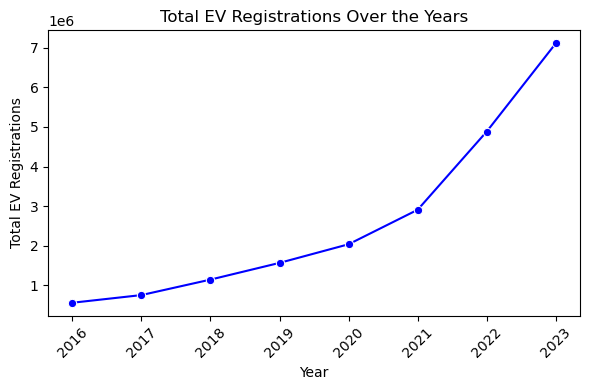

In [42]:
# Group the data by Year and sum EV registrations
annual_ev_registration = compiled_df.groupby('Year')['Electric'].sum().reset_index()

# Plotting total EV registrations over years
plt.figure(figsize=(6,4))
sns.lineplot(data=annual_ev_registration, x='Year', y='Electric', marker='o', color='blue')
plt.title('Total EV Registrations Over the Years')
plt.xlabel('Year')
plt.ylabel('Total EV Registrations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now we filter the data for the selected top 5 states ('California', 'Florida', 'Texas', 'Washington', 'New Jersey') and analyze their total EV registrations over the years

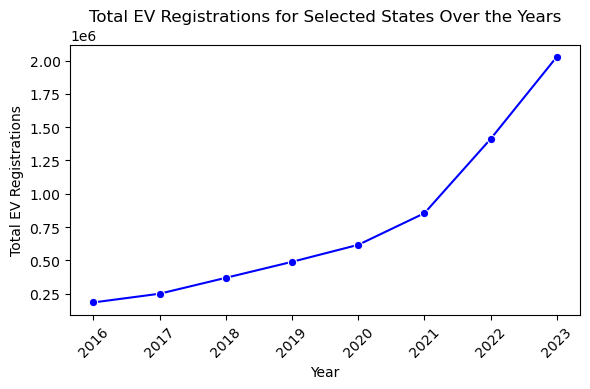

In [48]:
# Filter the data for the specified states
selected_states = ['California', 'Florida', 'Texas', 'Washington', 'New Jersey']
state_filtered_df = compiled_df[compiled_df['State'].isin(selected_states)]

# Group the data by Year and sum EV registrations for the selected states
annual_ev_registration = state_filtered_df.groupby('Year')['Electric'].sum().reset_index()

# Plotting total EV registrations over years for selected states
plt.figure(figsize=(6, 4))
sns.lineplot(data=annual_ev_registration, x='Year', y='Electric', marker='o', color='blue')
plt.title('Total EV Registrations for Top 5 States Over the Years')
plt.xlabel('Year')
plt.ylabel('Total EV Registrations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

To understand how EV registrations have changed over time across specific states, we add a state-level line plot of EV registrations over the years.

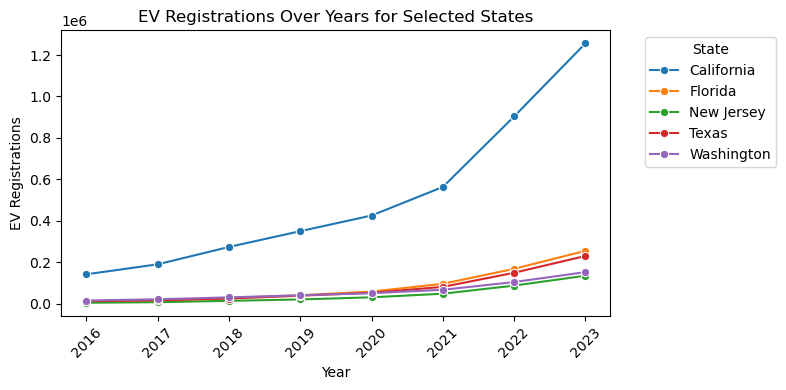

In [45]:
# Select the top 5 states
states_to_plot = ['California', 'Florida', 'Texas', 'Washington', 'New Jersey']
state_ev_data = compiled_df[compiled_df['State'].isin(states_to_plot)]

# Plotting EV registrations over years for selected states
plt.figure(figsize=(8, 4))
sns.lineplot(data=state_ev_data, x='Year', y='Electric', hue='State', marker='o', palette='tab10')
plt.title('EV Registrations Over Years for Selected States')
plt.xlabel('Year')
plt.ylabel('EV Registrations')
plt.xticks(rotation=45)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

3. **EV Manufacturer Suggested Retail Prices (by Models & Year)**

We want to explore the trend of average EV prices over the years. We first calculates the average EV price (MSRP) for each year.
And we plots the trend of EV prices over time, providing insights into how EV prices have changed year over year.

In [ ]:
# calculate the average MSRP by year
avg_prices_per_year = pricing_df_sorted.groupby('Year')['MSRP'].mean()

plt.plot(avg_prices_per_year.index, avg_prices_per_year.values, marker='o')
plt.title('Average EV Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Price (USD)')
plt.show()

Here we compute the annual registration and visualize the relationship between the average EV price and total EV registrations over the years on a single chart.

In [ ]:
annual_registrations = compiled_df.groupby('Year')['Electric'].sum()
print(annual_registrations.head())

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot the average EV price with ax1
ax1.set_xlabel('Year')
ax1.set_ylabel('Average EV Price (USD)', color='blue')
ax1.plot(avg_prices_per_year.index, avg_prices_per_year.values, label='Average EV Price',
         color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for total EV registrations
ax2 = ax1.twinx()
ax2.set_ylabel('Total EV Registrations', color='green')
ax2.plot(annual_registrations.index, annual_registrations.values, label='Total EV Registrations',
         color='green', marker='x')
ax2.tick_params(axis='y', labelcolor='green')

# Add title and legends
fig.suptitle('Average EV Price and Total EV Registrations by Year')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

Now we want to see the relationship between average EV prices and total EV registrations over the years. A scatter plot is used because it can show whether there's any correlation between the two variables

In [ ]:
registration_pricing_df = pd.merge(pricing_df_sorted, compiled_df, on='Year', how='inner')

# Group by Year to get the required aggregates
annual_data = registration_pricing_df.groupby('Year').agg({'Electric': 'sum', 'MSRP': 'mean'}).reset_index()

# Plot the relationship using a scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(annual_data['MSRP'], annual_data['Electric'], color='purple', marker='o')

# Add labels and title
plt.xlabel('Average EV Price (USD)')
plt.ylabel('Total EV Registrations')
plt.title('Relationship between Average EV Price and Total EV Registrations by Year')

plt.show()

We also group the registration_pricing_df DataFrame by both 'Year' and 'State' to calculate aggregates for each state in each year. This leads to a scatter plot where we visualize the relationship between average EV price (MSRP) and total EV registrations (Electric) for each state

In [ ]:
filtered_state_data = registration_pricing_df[registration_pricing_df['State']\
    .isin(['California', 'Florida', 'Texas', 'Washington', 'New Jersey'])]

state_annual_data = filtered_state_data.groupby(['Year', 'State']) \
    .agg({'Electric': 'sum', 'MSRP': 'mean'}).reset_index()

print(state_annual_data.head())

plt.figure(figsize=(6, 4))
filtered_scatterplot = sns.scatterplot(data=state_annual_data,\
                                       x='MSRP', y='Electric', hue='State')
plt.title('Average EV Price vs EV Registrations by State - Scatter Plot')
plt.xlabel('Average EV Price (USD)')
plt.ylabel('Total EV Registrations')
sns.move_legend(filtered_scatterplot, "upper left", bbox_to_anchor=(1, 1))
plt.show()

To visualize the relationship better, here we draw a line plot for ev pricing and registration

In [ ]:
s = sns.lineplot(data = state_annual_data, \
x = 'MSRP', y = 'Electric', marker = 'o', hue = 'State')
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.title("Average EV Price vs EV Registrations by State - Line Plot")
plt.show()

4. **Electric Vehicle Charge Stations**


In [ ]:
s = sns.lineplot(data = final_df, \
x = "Year", y = "TotalStations", marker = "o", hue = "State")
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.title("Total EV Stations From 2016-2023")
plt.show()

We can plot EV charge stations as `x` and EV registration as `y` to view the effect of charge stations on registration.

In [ ]:
s = sns.lineplot(data = final_df, \
x = "TotalStations", y = "Electric", marker = "o", hue = "State")
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.title("Total Stations vs. Total EV Registrations")
plt.show()

Since CA has disproportionately large amount of stations and EVs, let us plot CA separately.

In [ ]:
#all non-CA data
s = sns.lineplot(data = final_df.loc[final_df["State"] != "CA"], \
x = "TotalStations", y = "Electric", marker = "o", hue = "State")
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.title("Total Stations vs. Total EV Registrations")
plt.show()

#CA data
s = sns.lineplot(data = final_df.loc[final_df["State"] == "CA"], \
x = "TotalStations", y = "Electric", marker = "o", hue = "State")
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.title("CA: Total Stations vs. Total EV Registrations")
plt.show()

5. **Electric Vehicle Incentives**

**National-level Data** 

To analyze the effect of incentives on the number of EV registrations, we need to determine the growth trend. To do so, we must count the number of incentives in 2016, then add on additional incentives that were enacted in the years to follow. 

In [ ]:
# Count number of incentives up to 2016
national_2016 = national_incentives_df[national_incentives_df['Enacted Date'] <= 2016]
print(f"The number of incentives up to 2016 is {national_2016.shape[0]}.")

# Count number of incentives up to 2017
national_2017 = national_incentives_df[national_incentives_df['Enacted Date'] <= 2017]
print(f"The number of incentives up to 2017 is {national_2017.shape[0]}.")

# Count number of incentives up to 2018
national_2018 = national_incentives_df[national_incentives_df['Enacted Date'] <= 2018]
print(f"The number of incentives up to 2018 is {national_2018.shape[0]}.")

# Count number of incentives up to 2019
national_2019 = national_incentives_df[national_incentives_df['Enacted Date'] <= 2019]
print(f"The number of incentives up to 2019 is {national_2019.shape[0]}.")

# Count number of incentives up to 2020
national_2020 = national_incentives_df[national_incentives_df['Enacted Date'] <= 2020]
print(f"The number of incentives up to 2020 is {national_2020.shape[0]}.")

# Count number of incentives up to 2021
national_2021 = national_incentives_df[national_incentives_df['Enacted Date'] <= 2021]
print(f"The number of incentives up to 2021 is {national_2021.shape[0]}.")

# Count number of incentives up to 2022
national_2022 = national_incentives_df[national_incentives_df['Enacted Date'] <= 2022]
print(f"The number of incentives up to 2022 is {national_2022.shape[0]}.")

# Count number of incentives up to 2023
national_2023 = national_incentives_df[national_incentives_df['Enacted Date'] <= 2023]
print(f"The number of incentives up to 2023 is {national_2023.shape[0]}.")

Now that we have this information, we create a dataframe to visually represent the number of active federal incentives and the total number of electric vehicle (EV) adoptions for each year. The dataframe will include a "Year" column, a "Number of Active Federal Incentives" column, and an "EV Adoptions" column, which sums the total EV adoptions across all states for each respective year. This will allow us to see how the number of federal incentives correlates with EV adoption over time.

In [ ]:
# Create dataframe that shows total federal incentives compared to ev adoptions
years = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
federal_incentives = [national_2016.shape[0],
                      national_2017.shape[0],
                      national_2018.shape[0],
                      national_2019.shape[0],
                      national_2020.shape[0],
                      national_2021.shape[0],
                      national_2022.shape[0],
                      national_2023.shape[0]]

total_ev_per_year = compiled_df.groupby('Year')['Electric'].sum().reset_index()

federal_incentive_adoptions = pd.DataFrame({'Year': years, 
                                            'Federal Incentives Count': federal_incentives, 
                                            'EV Adoptions': (total_ev_per_year['Electric'])\
                                            .astype(int)})
federal_incentive_adoptions 

This leads to the scatter plot below that displays the number of active federal incentives from 2016 to 2023 against the total number of national EV adoptions within the timeframe of 2016-2023. 

In [ ]:
# Plot total number of incentives against total ev registrations per year 
federal_combined = sns.scatterplot(data = federal_incentive_adoptions, 
                                   x = "Federal Incentives Count",
                                   y = "EV Adoptions", marker = "o",
                                   hue = "Year", palette = sns.color_palette("Set2"),
                                  s = 100)
sns.move_legend(federal_combined, "upper left", bbox_to_anchor=(1, 1))
plt.title("Federal Incentives vs. Total EV Registrations (2016-2023)")
plt.show()

**State-level Data**

Here we are creating a dataframe that lists each state, year, and the number of EV adoptions within that specific year. This dataframe will be used later on when determining the incentive growth trend in each state. 

In [ ]:
# Sum EV adoptions per state and year from the compiled_df
ev_adoptions_per_state = compiled_df.groupby(['State', 'Year'])['Electric'] \
.sum().reset_index(name='EV Adoptions')

print(ev_adoptions_per_state.iloc[:20,:])

Now that we have a dataframe containing only information about electric vehicles, we need to track the growth of incentives in each state with active programs. This will involve accumulating the number of active incentives for each state starting in 2016 and then increasing the count based on whether new incentives were enacted in the following years. 

In [ ]:
# Define the start and end years
start_year = 2016
end_year = 2023

# Generate list of years from 2016 to 2023
years = list(range(start_year, end_year + 1))

# Get unique list of states
states = active_state_incentives_df['State'].unique()

# Initialize an empty list to store results
growth_data = []

# Loop over each state
for state in states:
    # Filter the incentives for the specific state
    state_incentives = active_state_incentives_df[
    active_state_incentives_df['State'] == state]
    
    # Create a dictionary to store cumulative incentive counts
    # per year for the state
    growth = {'State': state}
    
    # Initialize cumulative count
    cumulative_count = 0
    
    # Loop through each year from 2016 to 2023
    for year in years:
        # Count incentives that are still active in the `year`
        active_incentives = state_incentives[
            (state_incentives['Enacted Date'] <= year) & 
            ((state_incentives['Expired Date'] > year) |
             (state_incentives['Expired Date'].isna()))
        ]
        
        # Update the cumulative count for the current year
        cumulative_count = active_incentives.shape[0]
        
        # Add the count to the growth dictionary
        growth[year] = cumulative_count
        
    # Append the result to the list
    growth_data.append(growth)

# Convert the list of dictionaries to a dataframe
incentive_growth = pd.DataFrame(growth_data)

# Display the resulting dataframe
print(incentive_growth)

Based on the information above, now we are making a line plot showing how the number of active incentives for each state changed from 2016 to 2023. It goes through each state's data in the incentive_growth dataframe and plots their numbers for each year. The plot has labeled axes, a title, and a legend to help identify the different states.

In [ ]:
# Set figure size
plt.figure(figsize=(10, 8))

# Get the year columns (Get all columns except the first one)
year_columns = incentive_growth.columns[1:]  

# Function to plot each state
def plot_state(row):
    plt.plot(year_columns, row[year_columns].values, marker='o',
             label=row['State'])

# Apply function to each row of the incentive_growth df
incentive_growth.apply(plot_state, axis=1)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Active Incentives')
plt.title('Active Incentives Growth by State (2016-2023)')

# Add legend to see each state line separately
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

# Show the plot
plt.tight_layout()
plt.show()

Earlier, we determined that we will be focusing on California, Florida, Texas, Washington, and New Jersey. The following focuses on these five states and creates a line plot showing how the number of active incentives changed from 2016 to 2023. 

In [ ]:
# List of states we want to focus on
states_to_focus = ['California', 'Florida', 'Texas', 'Washington', 'New Jersey']

# Filter dataframe to only include these states
focused_incentive_growth = incentive_growth[incentive_growth['State'].isin(states_to_focus)]

# Loop through each state and plot its data
for state in states_to_focus:
    state_data = focused_incentive_growth[focused_incentive_growth['State'] == state]
     # Exclude the 'State' column
    plt.plot(state_data.columns[1:], state_data.iloc[0, 1:], marker='o', label=state) 

# Add labels and title, and legend
plt.xlabel('Year')
plt.ylabel('Number of Active Incentives')
plt.title('Active Incentives Growth for Selected States (2016-2023)')
plt.legend(title='State', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.show()

Now we have all of the information regarding the incentive trends and the total number of EV adoptions per year and per state. As a result, we can reshape the incentive_growth data into a long format and merge it with the electric vehicle (EV) adoption data for better analysis. We created separate line plots for California, Florida, Texas, Washington, and New Jersey, showing the growth of active incentives and the number of EV adoptions from 2016 to 2023. Each plot features two y-axes, with one showing active incentives in blue and the other showing EV adoptions in green. 

In [ ]:
# Reshape `incentive_growth` dataframe to long format
incentive_growth_long = pd.melt(incentive_growth, id_vars=['State'],
                                var_name='Year', value_name='Active_Incentives')

# Make sure 'Year' is treated as an integer for merging
incentive_growth_long['Year'] = incentive_growth_long['Year'].astype(int)

# Merge the incentives and EV adoption data
merged_ev_incentive_df = pd.merge(incentive_growth_long, ev_adoptions_per_state, on=['State', 'Year'])

# List of states to plot
states_to_plot = ['California', 'Florida', 'Texas', 'Washington', 'New Jersey']

# Set up the figure with subplots
fig, axes = plt.subplots(len(states_to_plot), 1, figsize=(10, 20))

# Access each subplot by index and plot the data
for i in range(len(states_to_plot)):
    state = states_to_plot[i]
    state_data = merged_ev_incentive_df[merged_ev_incentive_df['State'] == state]
    
    # Primary y-axis for Active Incentives
    ax1 = axes[i]
    ax1.plot(state_data['Year'], state_data['Active_Incentives'], color='blue',
             marker='o', label='Active Incentives')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Active Incentives', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_title(f'Comparison of Incentive Growth and EV Adoptions in {state} (2016-2023)')
    
    # Secondary y-axis for EV Adoptions
    ax2 = ax1.twinx()
    ax2.plot(state_data['Year'], state_data['EV Adoptions'], color='green', marker='x',
             linestyle='--', label='EV Adoptions')
    ax2.set_ylabel('Number of EV Adoptions', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## Data Limitations:
There are a few limitations in the data we’ve collected:

1. The current dataset only includes information from 2016 to 2023. This relatively narrow time range may hinder our ability to develop a reliable predictive model over a longer horizon. We are exploring additional sources to obtain data from earlier years, which may become more manageable once we narrow our focus to specific states.
2. The dataset is missing information for the year 2023. We are actively looking into potential sources that could help fill this gap.
4. Data only includes charge stations listed on open charge map, which might not include all the charging stations in the US. Data is limited for certain smaller states like Alaska or Delaware, leading to some missed data rows. 
5. Based on the incentives dataset, not all states provide incentives for electric vehicles. Additionally, there are missing values in the date columns, specifically at the state-level, that could lead to gaps when identifying active incentives. This causes further difficulty because without a sufficient amount of enactment and expired dates, we will be unable to accuratley analyze the trend in incentive growth per year and per state and compare that to the number of EV registrations. In order to fill the gaps in the data, we tried to manually search and implement both enactment and expired dates, and while we were successful for a few incentives, there still remains several missing dates.
6. Current pricing data includes only the models listed by the U.S. Department of Energy, which may not encompass all models available in the market. Also, while EV pricing remains relatively stable across states and years, it may still vary slightly due to differences in tax policies or overall economic conditions.

## Questions For Reviewers: 
* Do we need to explain any external sources referenced like we do in Homework assignments? (e.g. I had to scrape data from a pdf file, which was not covered in class.)
* In the scrapped EV pricing data, some EV model prices are displayed as a range. Currently, I’m calculating the median of the range and using that as the price for the corresponding model. Do you think this is a valid approach, or would you recommend a better method for handling range data?
* Should states without incentives be factored differently in our comparative analysis? If so, what are some suggestions?
* How do we handle missing data? E.g. if data is missing for Washington for a year, should we not build a model at all for Washington?
* For the pricing data, after we ran the explorative analysis on it, we realized that we're trying to find the the relationship beween a cummulative data (registration numbers) and non-cummulative data (average prices). How should we address this in our model? Can we still create a coefficient that reflects a relationship between average price and registration numbers? How would that be interpreted?
